# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

## Abstract
~Abstract Goes Here~

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions.

In [1]:
## IMPORTS ##
import eda_modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

### Starting with news
Starting with the news dataset, we first wanted to check some initial distributions. Out of the news dataset we can check the distributions of categories and sub-categories. Additionally, there is possibility for utilizing the URLs for web-scraping for further text analysis with natural language processing, however this is ICING :D. Visible below is initial distributions for news categories. 

In [2]:
news = pd.read_csv('../MIND_small/csv/news.csv')


In [3]:
fig = eda_modules.plot_sub_categories(news)
fig.show()

[]

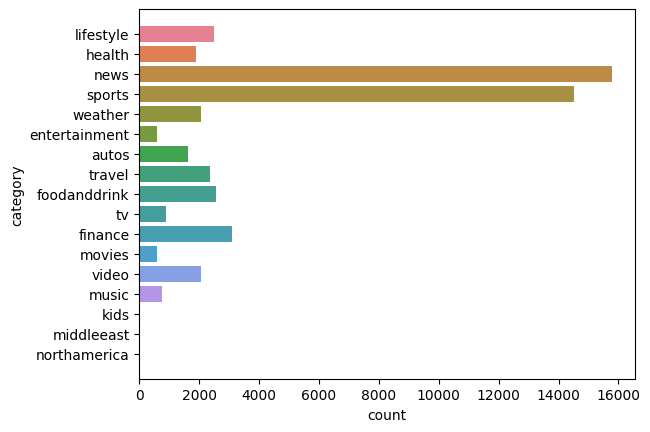

In [6]:
fig = eda_modules.plot_categories(news)
fig.plot()